In [1]:
using Random
using Geodesy
using StatsPlots

In [2]:
#import Pkg; Pkg.add("Geodesy")

In [3]:
#import Pkg; Pkg.add("StatsPlots")

In [4]:
#import Pkg
#Pkg.add("Distances")

In [5]:
using Random, Distributions

function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β) 
    extreme_value = rand(gumbel_dist)  
    return extreme_value > threshold  
end

teams = ["SEA", "LAR", "SF", "ARI", "DAL", "NYG", "PHI", "WAS",
         "TB", "CAR", "NO", "ATL", "MIN", "GB", "DET", "CHI",
         "BUF", "NYJ", "MIA", "NE", "HOU", "IND", "TEN", "JAG",
         "KC", "LAC", "DEN", "LV", "PIT", "CLE", "BAL", "CIN"]

stadium_coordinates = Dict(
    "SEA" => (47.595151, -122.331639), "LAR" => (34.014052, -118.287076),
    "ARI" => (33.5276, -112.2626), "SF" => (37.4032, -121.9703),
    "DAL" => (32.7474, -97.0945), "NYG" => (40.8121, -74.0772),
    "PHI" => (39.9008, -75.1675), "WAS" => (38.9078, -76.8645),
    "TB" => (27.9759, -82.5033), "CAR" => (35.2258, -80.8528),
    "NO" => (29.9599, -90.0813), "ATL" => (33.7554, -84.4009),
    "MIN" => (44.9738, -93.2580), "GB" => (44.5013, -88.0622),
    "DET" => (42.3400, -83.0456), "CHI" => (41.8623, -87.6167),
    "BUF" => (42.7739, -78.7870), "NYJ" => (40.8121, -74.0772),
    "MIA" => (25.9579, -80.2389), "NE" => (42.0909, -71.2643),
    "HOU" => (29.6847, -95.4199), "IND" => (39.7601, -86.1638),
    "TEN" => (36.1665, -86.7713), "JAG" => (30.3239, -81.6373),
    "KC" => (39.0489, -94.4839), "LAC" => (34.014052, -118.287076),
    "DEN" => (39.7439, -105.0201), "LV" => (36.0918, -115.1893),
    "PIT" => (40.4467, -80.0158), "CLE" => (41.5061, -81.6995),
    "BAL" => (39.2780, -76.6228), "CIN" => (39.0954, -84.5160)
)

international_games = Dict(
    1 => Dict("location" => "Sao Paulo", "coordinates" => (-23.55052, -46.63331)),
    5 => Dict("location" => "London", "coordinates" => (51.5074, -0.1278)),
    6 => Dict("location" => "London", "coordinates" => (51.5074, -0.1278)),
    7 => Dict("location" => "London", "coordinates" => (51.5074, -0.1278)),
    10 => Dict("location" => "Munich", "coordinates" => (48.1351, 11.5820))
)

bye_weeks = Dict("SEA" => 4, "LAR" => 7, "SF" => 9, "ARI" => 12, "DAL" => 11, "NYG" => 8, "PHI" => 13, "WAS" => 15,
                 "TB" => 6, "CAR" => 10, "NO" => 5, "ATL" => 14, "MIN" => 3, "GB" => 16, "DET" => 2, "CHI" => 18,
                 "BUF" => 1, "NYJ" => 17, "MIA" => 12, "NE" => 8, "HOU" => 11, "IND" => 9, "TEN" => 14, "JAG" => 4,
                 "KC" => 3, "LAC" => 13, "DEN" => 10, "LV" => 16, "PIT" => 7, "CLE" => 15, "BAL" => 5, "CIN" => 2)

function haversine(lat1, lon1, lat2, lon2)
    r = 6371  
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    a = sin(dlat / 2)^2 + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * sin(dlon / 2)^2
    c = 2 * atan(sqrt(a), sqrt(1 - a))
    return r * c
end

function calculate_distance(home_team, opponent, game_location, stadium_coordinates, international_games)
    if game_location == "Home"
        home_coords = stadium_coordinates[home_team]
        away_coords = stadium_coordinates[opponent]
        return haversine(home_coords[1], home_coords[2], away_coords[1], away_coords[2])
    else
        coords = international_games[game_location]["coordinates"]
        home_coords = stadium_coordinates[home_team]
        return haversine(home_coords[1], home_coords[2], coords[1], coords[2])
    end
end

schedule = Dict(week => Dict() for week in 1:18)
total_kilometers = 0.0

μ = 0  
β = 1  
threshold = 10.0  #bardzo rzadkie zdarzenie

teams_played = Dict(week => Set{String}() for week in 1:18)

for (week, details) in international_games
    city = details["location"]
    coords = details["coordinates"]
    host_team = Random.shuffle(teams)[1]
    available_opponents = setdiff(teams, [host_team])
    opponent = Random.shuffle(available_opponents)[1]
    if should_cancel_game_gumbel(μ, β, threshold)
        println("  [!] Game in week $week canceled in $city (reason: extreme event)")
        continue
    end
    distance = haversine(coords[1], coords[2], stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
    total_kilometers += distance
    schedule[week][host_team] = (opponent, city, distance)
    push!(teams_played[week], host_team, opponent)
end

for week in 1:18
    for team in teams
        if week == bye_weeks[team] || haskey(schedule[week], team) || team in teams_played[week]
            continue
        end
        if should_cancel_game_gumbel(μ, β, threshold)
            println("  [!] Game in week $week involving $team canceled (reason: extreme event)")
            continue
        end
        available_opponents = setdiff(teams, union([team], teams_played[week]))
        if !isempty(available_opponents)
            opponent = Random.shuffle(available_opponents)[1]
            distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
            total_kilometers += distance
            schedule[week][team] = (opponent, "Home", distance)
            push!(teams_played[week], team, opponent)
        end
    end
end

for week in 1:18
    println("Week $week:")
    for (team, (opponent, city, distance)) in schedule[week]
        println("  $team vs $opponent in $city, Distance: $(round(distance, digits=2)) km")
    end
end

println("\nTotal kilometers traveled by all teams: $(round(total_kilometers, digits=2)) km")

Week 1:
  CIN vs BUF in Sao Paulo, Distance: 8002.38 km
  NE vs BAL in Home, Distance: 549.35 km
  LAR vs PIT in Home, Distance: 3435.03 km
  SF vs PHI in Home, Distance: 4027.13 km
  DAL vs LV in Home, Distance: 1698.21 km
  NYG vs NYJ in Home, Distance: 0.0 km
  ARI vs TEN in Home, Distance: 2337.86 km
  NO vs DET in Home, Distance: 1513.23 km
  MIN vs MIA in Home, Distance: 2413.87 km
  TB vs HOU in Home, Distance: 1271.8 km
  SEA vs CAR in Home, Distance: 3669.94 km
  GB vs IND in Home, Distance: 549.91 km
  CHI vs DEN in Home, Distance: 1481.01 km
  KC vs CLE in Home, Distance: 1117.26 km
  ATL vs JAG in Home, Distance: 461.95 km
  WAS vs LAC in Home, Distance: 3712.1 km
Week 2:
  BUF vs IND in Home, Distance: 701.37 km
  LAR vs MIA in Home, Distance: 3749.56 km
  SF vs ATL in Home, Distance: 3399.28 km
  DAL vs KC in Home, Distance: 739.0 km
  PHI vs TEN in Home, Distance: 1096.76 km
  NYG vs NO in Home, Distance: 1881.65 km
  ARI vs TB in Home, Distance: 2899.44 km
  MIN vs PIT 

In [6]:
using Statistics
using Plots
using DataFrames


function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β)  
    extreme_value = rand(gumbel_dist)  
    return extreme_value > threshold  
end


function simulate_schedule!(international_assignments, μ, β, threshold, team_distances)
    schedule = Dict(week => Dict() for week in 1:18)
    weekly_distances = zeros(Float64, 18)
    total_kilometers = 0.0

   
    for (week, details) in international_games
        city = details["location"]
        coords = details["coordinates"]
        host_team = Random.shuffle(teams)[1]
        available_opponents = setdiff(teams, [host_team])
        opponent = Random.shuffle(available_opponents)[1]

        if should_cancel_game_gumbel(μ, β, threshold)
            println("[!] Mecz w tygodniu $week odwołany w $city z powodu ekstremalnego zdarzenia")
            continue  
        end

        distance = haversine(coords[1], coords[2], stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
        total_kilometers += distance
        weekly_distances[week] += distance
        schedule[week][host_team] = (opponent, city, distance)
        international_assignments[host_team] += 1  
        team_distances[host_team] += distance  
    end

   
    for week in 1:18
        for team in teams
            if week == bye_weeks[team] || haskey(schedule[week], team)
                continue
            end

            if should_cancel_game_gumbel(μ, β, threshold)
                println("[!] Mecz w tygodniu $week z udziałem $team odwołany z powodu ekstremalnego zdarzenia")
                continue
            end

            available_opponents = setdiff(teams, union([team], keys(schedule[week])))
            if !isempty(available_opponents)
                opponent = Random.shuffle(available_opponents)[1]
                distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
                total_kilometers += distance
                weekly_distances[week] += distance
                schedule[week][team] = (opponent, "Home", distance)
                team_distances[team] += distance  
            end
        end
    end

    return total_kilometers, weekly_distances
end

μ, β, threshold = 0, 0.05, 4.0

num_simulations = 100
results = Float64[]
weekly_totals = zeros(Float64, 18)
team_totals = Dict(team => 0.0 for team in teams)
international_assignments = Dict(team => 0 for team in teams)
weekly_distances_all_simulations = [zeros(Float64, 18) for _ in 1:num_simulations]

for sim in 1:num_simulations
    total_kilometers, weekly_distances = simulate_schedule!(international_assignments, μ, β, threshold, team_totals)
    push!(results, total_kilometers)
    weekly_totals .+= weekly_distances
    weekly_distances_all_simulations[sim] .= weekly_distances
end

In [7]:
median_weekly_distances = Float64[]
p5_weekly_distances = Float64[]
p95_weekly_distances = Float64[]

for week in 1:18
    distances_for_week = [sim[week] for sim in weekly_distances_all_simulations]
    push!(median_weekly_distances, median(distances_for_week))
    push!(p5_weekly_distances, quantile(distances_for_week, 0.05))
    push!(p95_weekly_distances, quantile(distances_for_week, 0.95))
end

In [8]:
average_weekly_distances = weekly_totals ./ num_simulations

average_team_distances = Dict(team => team_totals[team] / num_simulations for team in teams)

week_data = DataFrame(Week=1:18, AvgDistance=average_weekly_distances)

println("\nTabela średnich odległości pokonywanych w każdym tygodniu:")
println(week_data)

println("\nTabela średnich odległości pokonywanych przez zespół w sezonie:")
println(average_team_distances)


Tabela średnich odległości pokonywanych w każdym tygodniu:
18×2 DataFrame
 Row │ Week   AvgDistance 
     │ Int64  Float64     
─────┼────────────────────
   1 │     1      55248.5
   2 │     2      48497.7
   3 │     3      47536.1
   4 │     4      51397.7
   5 │     5      54445.7
   6 │     6      55661.0
   7 │     7      56467.9
   8 │     8      48829.4
   9 │     9      50860.2
  10 │    10      54852.9
  11 │    11      50277.0
  12 │    12      51123.7
  13 │    13      49274.1
  14 │    14      48454.2
  15 │    15      48003.0
  16 │    16      49779.1
  17 │    17      48872.6
  18 │    18      47652.6

Tabela średnich odległości pokonywanych przez zespół w sezonie:
Dict("DET" => 20736.418809284292, "BUF" => 23419.669509983523, "CIN" => 22090.718224021042, "HOU" => 28243.75220761682, "PIT" => 11987.837424892356, "CLE" => 15034.953803259703, "MIA" => 34223.92026446122, "NE" => 33167.2230143311, "IND" => 19259.239451092646, "TEN" => 22245.24675604762, "LAR" => 48509.7864891

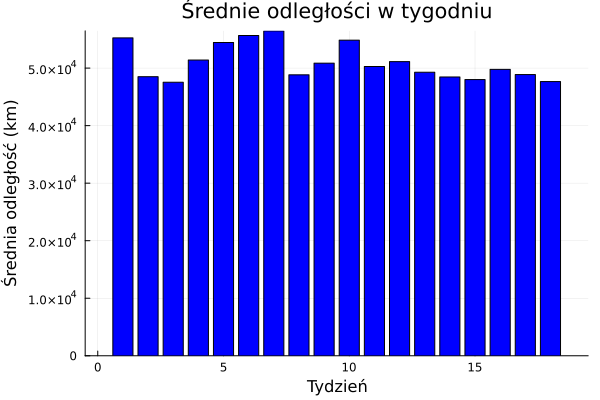

In [9]:
bar(
    week_data.Week,
    week_data.AvgDistance,
    xlabel="Tydzień",
    ylabel="Średnia odległość (km)",
    title="Średnie odległości w tygodniu",
    label="Weekly Avg Dist",
    color=:blue,
    legend=false
)

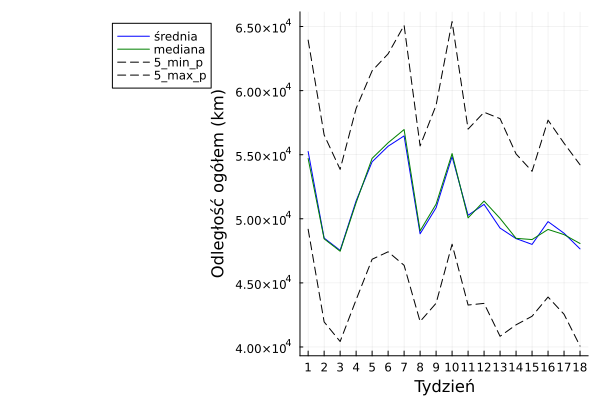

In [10]:
p = plot(titlefontsize=10, xlabel="Tydzień", ylabel="Odległość ogółem (km)", left_margin=6Plots.mm, legend=:outertopleft)

    plot!(p, 1:18, average_weekly_distances, color=:blue, linestyle=:solid, label="średnia")
    plot!(p, 1:18, median_weekly_distances, color=:green, linestyle=:solid, label="mediana")
    plot!(p, 1:18, p5_weekly_distances, color=:black, linestyle=:dash, label="5_min_p")
    plot!(p, 1:18, p95_weekly_distances, color=:black, linestyle=:dash, label="5_max_p")
    xticks!(1:18)

In [11]:
team_data = DataFrame(Team=collect(keys(average_team_distances)), AvgDistance=collect(values(average_team_distances)))

sort!(team_data, :AvgDistance, rev=true)

println("\nTabela średnich odległości pokonywanych przez drużyny:")
println(team_data)


Tabela średnich odległości pokonywanych przez drużyny:
32×2 DataFrame
 Row │ Team    AvgDistance 
     │ String  Float64     
─────┼─────────────────────
   1 │ SF          53005.2
   2 │ SEA         51446.9
   3 │ LV          48986.3
   4 │ LAR         48509.8
   5 │ LAC         44842.0
   6 │ ARI         43668.2
   7 │ MIA         34223.9
   8 │ NE          33167.2
   9 │ DEN         33071.6
  10 │ JAG         32269.1
  11 │ HOU         28243.8
  12 │ DAL         27900.2
  13 │ NYJ         27737.1
  14 │ TB          27241.5
  15 │ NO          26197.2
  16 │ KC          24558.8
  17 │ MIN         23857.6
  18 │ BUF         23419.7
  19 │ ATL         22571.1
  20 │ PHI         22415.0
  21 │ NYG         22372.8
  22 │ TEN         22245.2
  23 │ CIN         22090.7
  24 │ GB          21831.7
  25 │ WAS         21407.3
  26 │ CHI         21171.3
  27 │ CAR         21037.0
  28 │ DET         20736.4
  29 │ BAL         20726.9
  30 │ IND         19259.2
  31 │ CLE         15035.0
  32 │ P

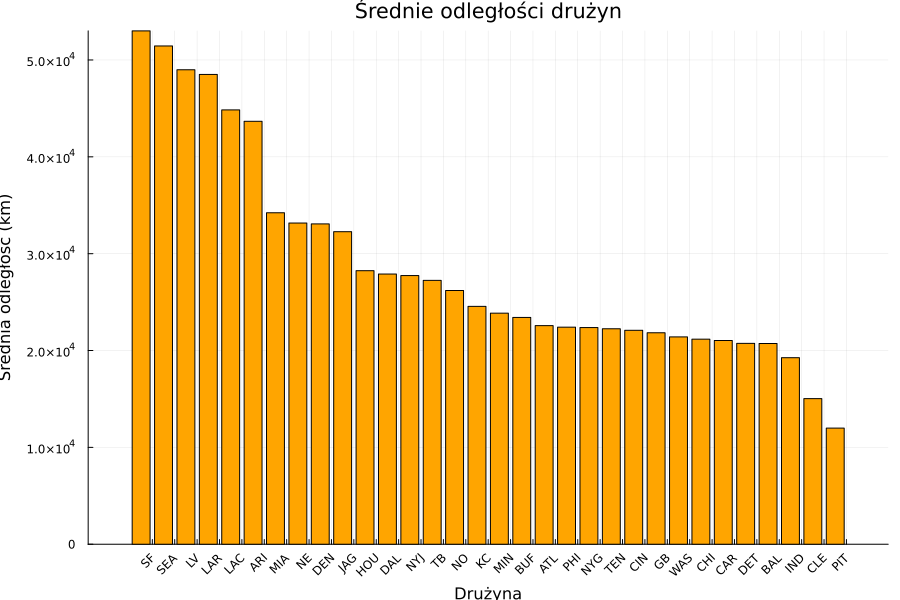

In [12]:
bar(
    team_data.Team,
    team_data.AvgDistance,
    xlabel="Drużyna",
    ylabel="Średnia odległość (km)",
    title="Średnie odległości drużyn",
    label="Team Avg Distances",
    color=:orange,
    legend=false,
    xticks=(1:length(team_data.Team), team_data.Team),  
    size=(900, 600),  
    xrotation=45
)


Average Total Kilometers: 917233.44
Standard Deviation of Total Kilometers: 18949.92


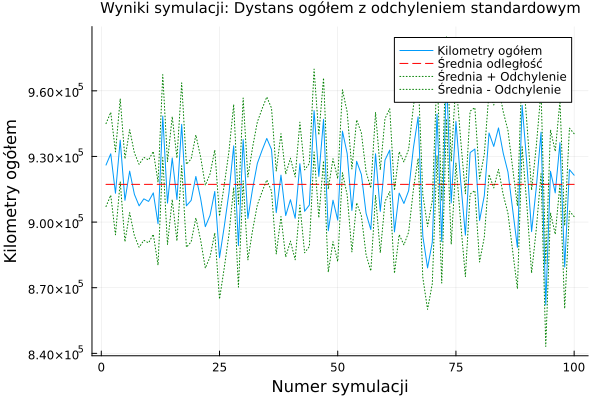

In [13]:
avg_distance = mean(results)
std_dev_distance = std(results)

println("\nAverage Total Kilometers: ", round(avg_distance, digits=2))
println("Standard Deviation of Total Kilometers: ", round(std_dev_distance, digits=2))

simulation_runs = 1:num_simulations
plot(simulation_runs, results, label="Kilometry ogółem", xlabel="Numer symulacji", ylabel="Kilometry ogółem", titlefontsize=10,
     title="Wyniki symulacji: Dystans ogółem z odchyleniem standardowym", lw=1, legend=:topright)
plot!(simulation_runs, fill(avg_distance, num_simulations), label="Średnia odległość", linestyle=:dash, color=:red)
plot!(simulation_runs, results .+ std_dev_distance, label="Średnia + Odchylenie", linestyle=:dot, color=:green)
plot!(simulation_runs, results .- std_dev_distance, label="Średnia - Odchylenie", linestyle=:dot, color=:green)

In [14]:
using Statistics, Random, Distributions

divisions = Dict(
    "NFC_West" => ["SEA", "LAR", "SF", "ARI"],
    "NFC_East" => ["DAL", "NYG", "PHI", "WAS"],
    "NFC_South" => ["TB", "CAR", "NO", "ATL"],
    "NFC_North" => ["MIN", "GB", "DET", "CHI"],
    "AFC_East" => ["BUF", "NYJ", "MIA", "NE"],
    "AFC_South" => ["HOU", "IND", "TEN", "JAG"],
    "AFC_West" => ["KC", "LAC", "DEN", "LV"],
    "AFC_North" => ["PIT", "CLE", "BAL", "CIN"]
)

function is_division_game(team1, team2, divisions)
    for (_, teams) in divisions
        if team1 in teams && team2 in teams
            return true
        end
    end
    return false
end

function find_closest_opponent_with_limit(home_team, available_opponents, stadium_coordinates, divisions, max_derby_games, division_game_count)
    distances = Dict(opponent => haversine(stadium_coordinates[home_team][1], stadium_coordinates[home_team][2],
                                           stadium_coordinates[opponent][1], stadium_coordinates[opponent][2])
                     for opponent in available_opponents)

   
    sorted_opponents = sort(collect(distances), by=x -> x[2])

    for (opponent, _) in sorted_opponents
        if is_division_game(home_team, opponent, divisions)
            if division_game_count[home_team] >= max_derby_games || division_game_count[opponent] >= max_derby_games
                continue #losowany jest inny przeciwnik
            end
        end
        return opponent  
    end
    return nothing 
end

function generate_min_distance_schedule(μ, β, threshold, max_derby_games)
    schedule = Dict(week => Dict() for week in 1:18)
    total_kilometers = 0.0
    teams_played = Dict(week => Set{String}() for week in 1:18)
    division_game_count = Dict(team => 0 for team in teams) 

    
    for (week, details) in international_games
        city = details["location"]
        coords = details["coordinates"]
        host_team = Random.shuffle(teams)[1]
        available_opponents = setdiff(teams, [host_team])
        opponent = find_closest_opponent_with_limit(host_team, available_opponents, stadium_coordinates, divisions, max_derby_games, division_game_count)

        if opponent === nothing || should_cancel_game_gumbel(μ, β, threshold)
            println("  [!] Game in week $week canceled in $city (reason: extreme event or no valid opponent)")
            continue
        end

        distance = haversine(coords[1], coords[2], stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
        total_kilometers += distance
        schedule[week][host_team] = (opponent, city, distance)
        push!(teams_played[week], host_team, opponent)

        if is_division_game(host_team, opponent, divisions)
            division_game_count[host_team] += 1
            division_game_count[opponent] += 1
        end
    end

   
    for week in 1:18
        for team in teams
            if week == bye_weeks[team] || haskey(schedule[week], team) || team in teams_played[week]
                continue
            end
            if should_cancel_game_gumbel(μ, β, threshold)
                println("  [!] Game in week $week involving $team canceled (reason: extreme event)")
                continue
            end

            available_opponents = setdiff(teams, union([team], teams_played[week]))
            if !isempty(available_opponents)
                opponent = find_closest_opponent_with_limit(team, available_opponents, stadium_coordinates, divisions, max_derby_games, division_game_count)
                if opponent === nothing
                    println("  [!] No valid opponent for $team in week $week")
                    continue
                end

                distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
                total_kilometers += distance
                schedule[week][team] = (opponent, "Home", distance)
                push!(teams_played[week], team, opponent)

                if is_division_game(team, opponent, divisions)
                    division_game_count[team] += 1
                    division_game_count[opponent] += 1
                end
            end
        end
    end

    return schedule, total_kilometers
end


μ = 0  
β = 1  
threshold = 4.0  
max_derby_games = 2  

schedule, total_kilometers = generate_min_distance_schedule(μ, β, threshold, max_derby_games)

for week in 1:18
    println("Week $week:")
    for (team, (opponent, city, distance)) in schedule[week]
        println("  $team vs $opponent in $city, Distance: $(round(distance, digits=2)) km")
    end
end

println("\nTotal kilometers traveled by all teams: $(round(total_kilometers, digits=2)) km")


  [!] Game in week 1 involving DET canceled (reason: extreme event)
  [!] Game in week 5 involving NE canceled (reason: extreme event)
  [!] No valid opponent for BUF in week 8
  [!] Game in week 10 involving SEA canceled (reason: extreme event)
  [!] No valid opponent for MIA in week 11
  [!] No valid opponent for NE in week 11
  [!] No valid opponent for MIA in week 13
  [!] No valid opponent for NE in week 13
  [!] No valid opponent for MIA in week 14
  [!] No valid opponent for NE in week 14
  [!] Game in week 15 involving NO canceled (reason: extreme event)
  [!] No valid opponent for MIA in week 16
  [!] No valid opponent for NE in week 16
  [!] No valid opponent for MIA in week 17
  [!] No valid opponent for NE in week 17
  [!] Game in week 18 involving NO canceled (reason: extreme event)
Week 1:
  CLE vs DET in Home, Distance: 144.91 km
  MIA vs CIN in Home, Distance: 1514.33 km
  NE vs BUF in Home, Distance: 621.83 km
  LAR vs LAC in Home, Distance: 0.0 km
  DAL vs HOU in Sao 

In [15]:
using Statistics, Plots, Random, Distributions

function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β)
    extreme_value = rand(gumbel_dist)
    return extreme_value > threshold
end

divisions = Dict(
    "NFC West" => ["SEA", "LAR", "SF", "ARI"],
    "NFC East" => ["DAL", "NYG", "PHI", "WAS"],
    "NFC North" => ["MIN", "GB", "DET", "CHI"],
    "NFC South" => ["TB", "CAR", "NO", "ATL"],
    "AFC West" => ["KC", "LAC", "DEN", "LV"],
    "AFC East" => ["BUF", "NYJ", "MIA", "NE"],
    "AFC North" => ["PIT", "CLE", "BAL", "CIN"],
    "AFC South" => ["HOU", "IND", "TEN", "JAG"]
)

function same_division(team1, team2, divisions)
    for (_, teams) in divisions
        if team1 in teams && team2 in teams
            return true
        end
    end
    return false
end

function sensitivity_analysis(max_home_streak::Int, max_division_matches::Int)
    println("\n--- Analiza Wrażliwości ---")
    println("Maksymalna liczba meczów u siebie z rzędu: $max_home_streak")
    println("Maksymalna liczba meczów dywizji z rzędu: $max_division_matches")

    home_streak = Dict(team => 0 for team in teams)
    division_streak = Dict(team => 0 for team in teams)
    teams_played = Dict(week => Set() for week in 1:18)
    schedule = Dict(week => Dict() for week in 1:18)
    total_kilometers = 0.0
    weekly_distances = zeros(Float64, 18)
    team_distances = Dict(team => 0.0 for team in teams)

    μ, β, threshold = 0, 0.05, 4.0 

    for (week, details) in international_games
        city = details["location"]
        host_team = Random.shuffle(teams)[1]
        available_opponents = setdiff(teams, [host_team])
        opponent = Random.shuffle(available_opponents)[1]
        if should_cancel_game_gumbel(μ, β, threshold)
            println("  [!] Mecz w tygodniu $week odwołany w $city (przyczyna: ekstremalne zdarzenie)")
            continue
        end
        distance = haversine(details["coordinates"][1], details["coordinates"][2],
                              stadium_coordinates[host_team][1], stadium_coordinates[host_team][2])
        total_kilometers += distance
        schedule[week][host_team] = (opponent, city, distance)
        teams_played[week] = union(teams_played[week], [host_team, opponent])
        weekly_distances[week] += distance
        team_distances[host_team] += distance
    end

    for week in 1:18
        for team in teams
            if week == bye_weeks[team] || haskey(schedule[week], team) || team in teams_played[week]
                continue
            end
            if should_cancel_game_gumbel(μ, β, threshold)
                println("  [!] Mecz w tygodniu $week z udziałem $team odwołany (przyczyna: ekstremalne zdarzenie)")
                continue
            end
            available_opponents = setdiff(teams, union([team], keys(schedule[week]), collect(teams_played[week])))

           
            available_opponents = filter(o -> !(same_division(team, o, divisions) && division_streak[team] >= max_division_matches), available_opponents)

            if !isempty(available_opponents)
                opponent = Random.shuffle(available_opponents)[1]
                distance = calculate_distance(team, opponent, "Home", stadium_coordinates, international_games)
                total_kilometers += distance
                schedule[week][team] = (opponent, "Home", distance)
                teams_played[week] = union(teams_played[week], [team, opponent])
                weekly_distances[week] += distance
                team_distances[team] += distance

            
                if same_division(team, opponent, divisions)
                    division_streak[team] += 1
                else
                    division_streak[team] = 0
                end
            end
        end
    end

   
    for week in 1:18
        println("Week $week:")
        for (team, (opponent, city, distance)) in schedule[week]
            println("  $team vs $opponent in $city, Distance: $(round(distance, digits=2)) km")
        end
    end

    println("\nŁączna liczba kilometrów przejechanych przez wszystkie drużyny: $(round(total_kilometers, digits=2)) km")

    
    average_weekly_distances = weekly_distances ./ length(teams)
    println("\nŚrednie tygodniowe odległości:")
    week_data = DataFrame(Week=1:18, AvgDistance=average_weekly_distances)
    println(week_data)

    
    average_team_distances = Dict(k => v / 18 for (k, v) in team_distances)
    println("\nŚrednie odległości pokonywane przez drużyny:")
    team_data = DataFrame(Team=collect(keys(average_team_distances)), AvgDistance=collect(values(average_team_distances)))
    sort!(team_data, :AvgDistance, rev=true)
    println(team_data)

    
    bar(
        week_data.Week,
        week_data.AvgDistance,
        xlabel="Week",
        ylabel="Average Distance (km)",
        title="Average Weekly Distances",
        color=:blue,
        legend=false
    )

   
    bar(
        team_data.Team,
        team_data.AvgDistance,
        xlabel="Team",
        ylabel="Average Distance (km)",
        title="Average Team Distances",
        color=:orange,
        legend=false,
        xticks=(1:length(team_data.Team), team_data.Team),
        size=(900, 600),
        xrotation=45
    )
end


sensitivity_analysis (generic function with 1 method)


Analiza wrażliwości: Limit 4 mecze u siebie, maksymalnie 2 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 4
Maksymalna liczba meczów dywizji z rzędu: 2
Week 1:
  DET vs JAG in Home, Distance: 1342.01 km
  HOU vs BAL in Home, Distance: 2020.15 km
  CLE vs CIN in Sao Paulo, Distance: 8085.62 km
  MIA vs IND in Home, Distance: 1630.41 km
  LAR vs DEN in Home, Distance: 1339.05 km
  SF vs NE in Home, Distance: 4302.67 km
  DAL vs TEN in Home, Distance: 1019.3 km
  PHI vs CHI in Home, Distance: 1068.07 km
  NYG vs CAR in Home, Distance: 858.6 km
  ARI vs WAS in Home, Distance: 3210.66 km
  NO vs BUF in Home, Distance: 1743.7 km
  MIN vs NYJ in Home, Distance: 1625.19 km
  TB vs LAC in Home, Distance: 3458.19 km
  SEA vs ATL in Home, Distance: 3504.01 km
  GB vs KC in Home, Distance: 806.41 km
  LV vs PIT in Home, Distance: 3087.82 km
Week 2:
  BUF vs CIN in Home, Distance: 631.32 km
  LAR vs IND in Home, Distance: 2910.92 km
  SF vs TEN in Home, Dis

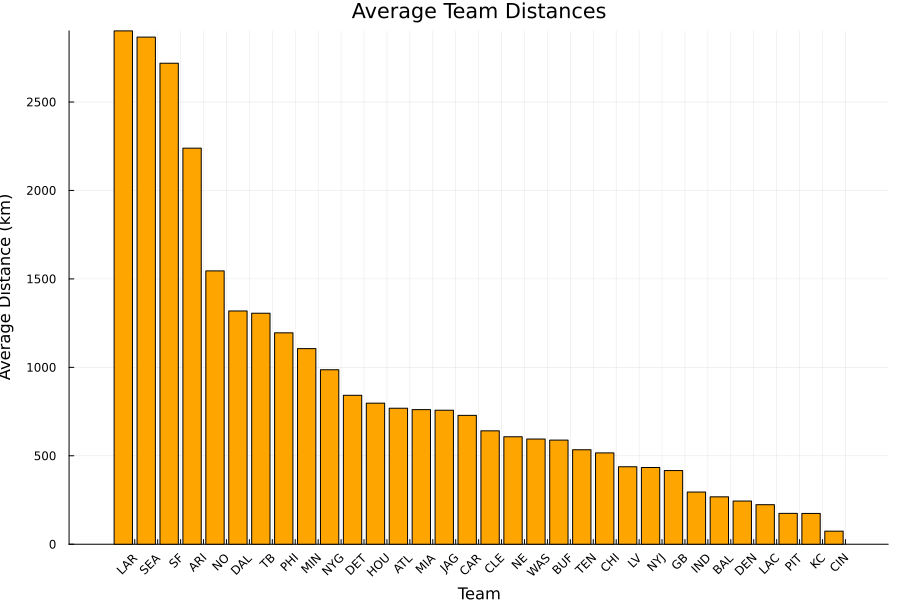

In [16]:
println("\nAnaliza wrażliwości: Limit 4 mecze u siebie, maksymalnie 2 mecze z dywizji")
sensitivity_analysis(4, 2)


Analiza wrażliwości: Limit 3 mecze u siebie, maksymalnie 4 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 3
Maksymalna liczba meczów dywizji z rzędu: 4
Week 1:
  MIA vs JAG in Home, Distance: 504.45 km
  IND vs PIT in Home, Distance: 528.33 km
  TEN vs CLE in Home, Distance: 738.27 km
  LAR vs LV in Home, Distance: 364.5 km
  SF vs PHI in Home, Distance: 4027.13 km
  DAL vs BAL in Home, Distance: 1973.75 km
  NYG vs LAC in Home, Distance: 3934.46 km
  ARI vs DET in Home, Distance: 2726.7 km
  NO vs ATL in Home, Distance: 682.38 km
  CHI vs NYJ in Home, Distance: 1135.22 km
  TB vs NE in Home, Distance: 1869.82 km
  SEA vs CIN in Home, Distance: 3165.25 km
  GB vs MIN in Sao Paulo, Distance: 8658.52 km
  CAR vs HOU in Home, Distance: 1497.2 km
  DEN vs BUF in Home, Distance: 2209.38 km
  WAS vs KC in Home, Distance: 1520.73 km
Week 2:
  BUF vs HOU in Home, Distance: 2076.85 km
  MIA vs PIT in Home, Distance: 1611.21 km
  NE vs LAC in Home, Dista

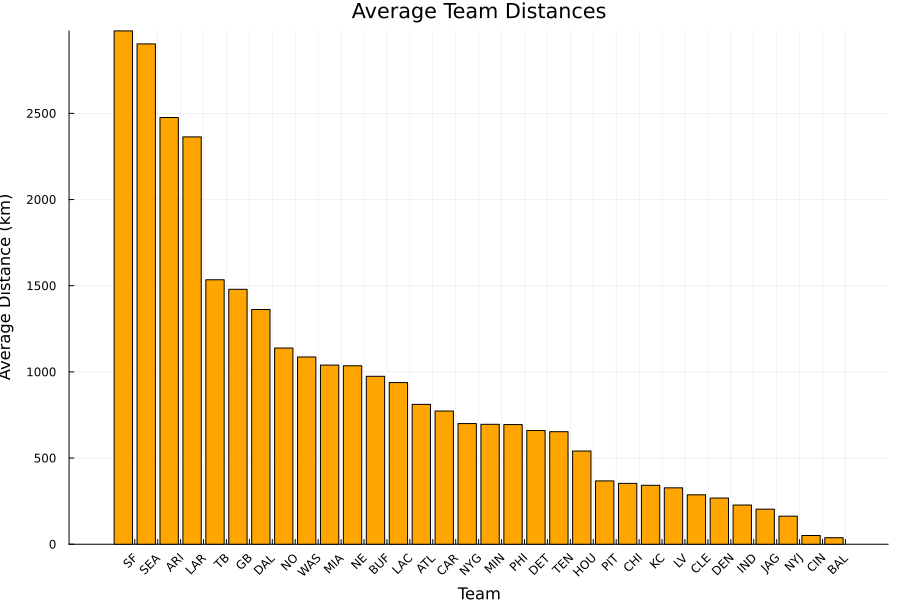

In [17]:
println("\nAnaliza wrażliwości: Limit 3 mecze u siebie, maksymalnie 4 mecze z dywizji")
sensitivity_analysis(3, 4)


Analiza wrażliwości: Limit 4 mecze u siebie, maksymalnie 3 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 4
Maksymalna liczba meczów dywizji z rzędu: 3
Week 1:
  DET vs JAG in Home, Distance: 1342.01 km
  MIA vs TEN in Home, Distance: 1293.62 km
  IND vs BAL in Home, Distance: 819.76 km
  SF vs GB in Home, Distance: 2931.7 km
  DAL vs PIT in Home, Distance: 1744.16 km
  PHI vs NE in Home, Distance: 408.11 km
  NYG vs CAR in Home, Distance: 858.6 km
  ARI vs DEN in Home, Distance: 945.58 km
  NO vs KC in Home, Distance: 1087.8 km
  MIN vs HOU in Home, Distance: 1710.61 km
  TB vs CHI in Home, Distance: 1612.12 km
  SEA vs NYJ in Home, Distance: 3855.18 km
  ATL vs CIN in Home, Distance: 593.87 km
  LV vs LAR in Sao Paulo, Distance: 9781.66 km
  LAC vs CLE in Home, Distance: 3295.92 km
  WAS vs BUF in Home, Distance: 459.27 km
Week 2:
  IND vs PIT in Home, Distance: 528.33 km
  LAR vs NYJ in Home, Distance: 3934.46 km
  SF vs LV in Home, Distance

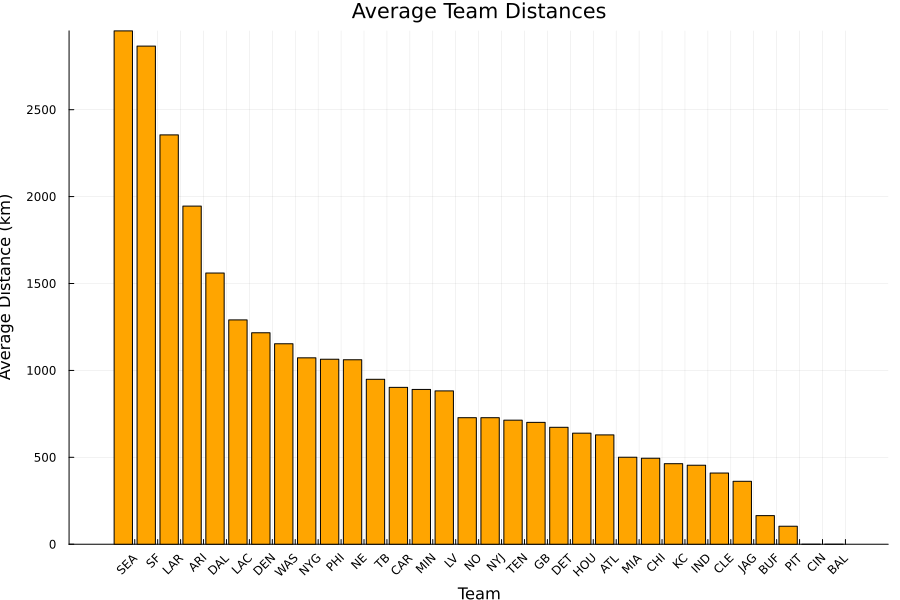

In [18]:
println("\nAnaliza wrażliwości: Limit 4 mecze u siebie, maksymalnie 3 mecze z dywizji")
sensitivity_analysis(4, 3)


Analiza wrażliwości: Limit 2 mecze u siebie, maksymalnie 3 mecze z dywizji

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 2
Maksymalna liczba meczów dywizji z rzędu: 3
Week 1:
  CIN vs BUF in Home, Distance: 631.32 km
  HOU vs LAC in Home, Distance: 2207.85 km
  NE vs CLE in Home, Distance: 866.92 km
  LAR vs DET in Home, Distance: 3190.97 km
  SF vs MIN in Home, Distance: 2529.94 km
  PHI vs PIT in Home, Distance: 416.32 km
  NYG vs MIA in Home, Distance: 1746.74 km
  ARI vs TB in Home, Distance: 2899.44 km
  NO vs CHI in Home, Distance: 1341.8 km
  DEN vs DAL in Sao Paulo, Distance: 9279.55 km
  SEA vs NYJ in Home, Distance: 3855.18 km
  CAR vs TEN in Home, Distance: 544.51 km
  GB vs IND in Home, Distance: 549.91 km
  ATL vs JAG in Home, Distance: 461.95 km
  KC vs LV in Home, Distance: 1850.02 km
  WAS vs BAL in Home, Distance: 46.15 km
Week 2:
  MIA vs DEN in Home, Distance: 2761.38 km
  IND vs JAG in Home, Distance: 1126.84 km
  TEN vs LAC in Home, Dista

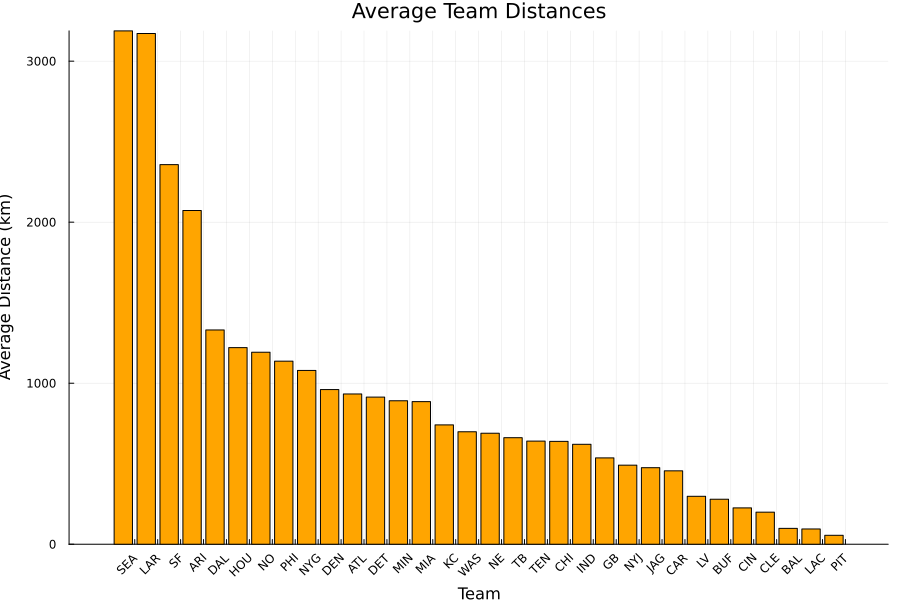

In [19]:
println("\nAnaliza wrażliwości: Limit 2 mecze u siebie, maksymalnie 3 mecze z dywizji")
sensitivity_analysis(2, 3)


Analiza wrażliwości: Limit 1 mecz u siebie z rzędu, maksymalnie 2 mecze dywizji z rzędu

--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 1
Maksymalna liczba meczów dywizji z rzędu: 2
Week 1:
  CIN vs CAR in Sao Paulo, Distance: 8002.38 km
  HOU vs JAG in Home, Distance: 1328.26 km
  TEN vs KC in Home, Distance: 750.85 km
  LAR vs PIT in Home, Distance: 3435.03 km
  SF vs NE in Home, Distance: 4302.67 km
  DAL vs DET in Home, Distance: 1630.68 km
  BAL vs BUF in Home, Distance: 428.99 km
  PHI vs LAC in Home, Distance: 3848.99 km
  NYG vs WAS in Home, Distance: 318.46 km
  ARI vs IND in Home, Distance: 2419.54 km
  NO vs DEN in Home, Distance: 1739.9 km
  MIN vs CLE in Home, Distance: 1011.41 km
  TB vs ATL in Home, Distance: 667.64 km
  SEA vs MIA in Home, Distance: 4377.0 km
  GB vs CHI in Home, Distance: 295.66 km
  NYJ vs LV in Home, Distance: 3585.13 km
Week 2:
  BUF vs PIT in Home, Distance: 278.2 km
  IND vs LV in Home, Distance: 2566.81 km
  LAR vs NO in 

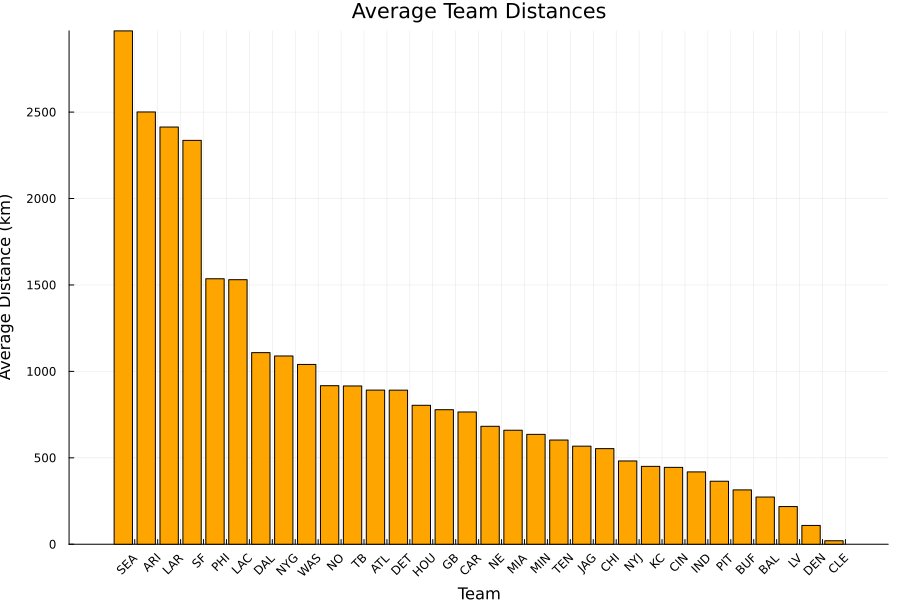

In [20]:
println("\nAnaliza wrażliwości: Limit 1 mecz u siebie z rzędu, maksymalnie 2 mecze dywizji z rzędu")
sensitivity_analysis(1, 2)


--- Analiza Wrażliwości ---
Maksymalna liczba meczów u siebie z rzędu: 3
Maksymalna liczba meczów dywizji z rzędu: 2
Week 1:
  DET vs BAL in Home, Distance: 638.57 km
  SF vs MIA in Home, Distance: 4111.49 km
  PHI vs LV in Home, Distance: 3503.06 km
  NYG vs CAR in Home, Distance: 858.6 km
  ARI vs WAS in Home, Distance: 3210.66 km
  NO vs HOU in Home, Distance: 515.87 km
  MIN vs CLE in Home, Distance: 1011.41 km
  TB vs IND in Home, Distance: 1352.87 km
  SEA vs DAL in Home, Distance: 2685.43 km
  GB vs NE in Home, Distance: 1383.0 km
  CHI vs CIN in Home, Distance: 404.21 km
  KC vs PIT in Home, Distance: 1245.23 km
  ATL vs DEN in Home, Distance: 1948.57 km
  LAC vs BUF in Home, Distance: 3542.18 km
  NYJ vs TEN in Home, Distance: 1218.04 km
  JAG vs LAR in Sao Paulo, Distance: 7059.28 km
Week 2:
  MIA vs LAC in Home, Distance: 3749.56 km
  TEN vs LV in Home, Distance: 2543.03 km
  LAR vs BAL in Home, Distance: 3729.69 km
  SF vs NYJ in Home, Distance: 4098.32 km
  DAL vs PIT in 

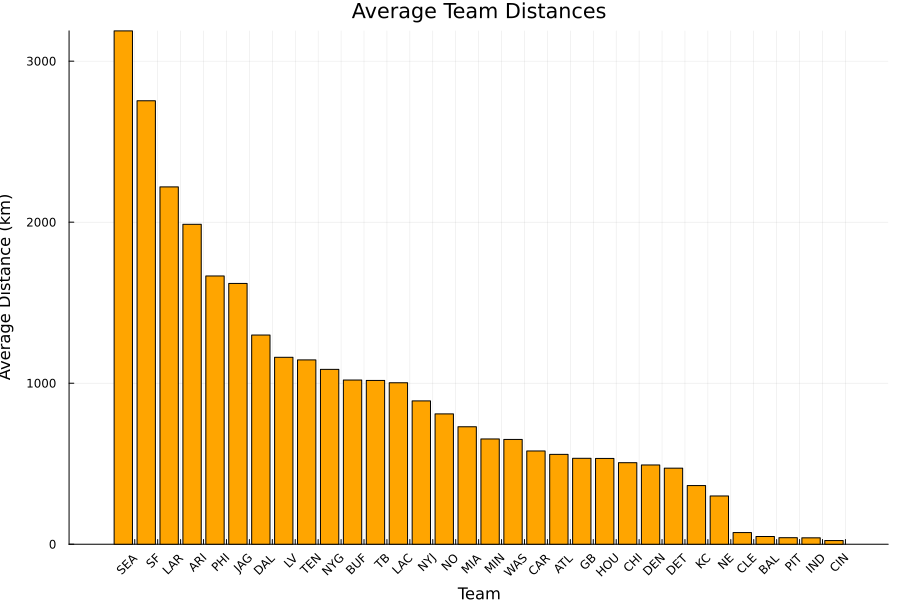

In [21]:
sensitivity_analysis(3, 2) 

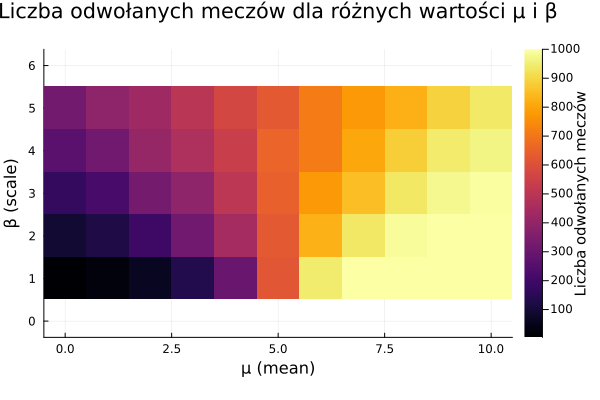

In [22]:
using Distributions
using Plots

function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β)  
    extreme_value = rand(gumbel_dist)  
    return extreme_value > threshold  
end


function simulate_schedule(international_assignments, μ, β, threshold)
    canceled_matches = 0
    for _ in 1:international_assignments
        if should_cancel_game_gumbel(μ, β, threshold)
            canceled_matches += 1
        end
    end
    return canceled_matches
end


international_assignments = 1000  
threshold = 5.0  


μ_values = 0:1:10  
β_values = 1:1:5  


results = zeros(Float64, length(μ_values), length(β_values))

for i in 1:length(μ_values)
    for j in 1:length(β_values)
        μ = μ_values[i]
        β = β_values[j]
        results[i, j] = simulate_schedule(international_assignments, μ, β, threshold)
    end
end

heatmap(μ_values, β_values, results',
    xlabel = "μ (mean)",
    ylabel = "β (scale)",
    title = "Liczba odwołanych meczów dla różnych wartości μ i β",
    colorbar_title = "Liczba odwołanych meczów",
    aspect_ratio = :equal
)


In [23]:
using Plots
using DataFrames


function should_cancel_game_gumbel(μ, β, threshold)
    gumbel_dist = Gumbel(μ, β) 
    extreme_value = rand(gumbel_dist) 
    return extreme_value > threshold 
end

function simulate_schedule(μ_values, β_values, threshold, num_simulations)
    results = DataFrame(μ = Float64[], β = Float64[], canceled_games = Int[])
    
    for μ in μ_values, β in β_values
        canceled_count = 0
        for _ in 1:num_simulations
            if should_cancel_game_gumbel(μ, β, threshold)
                canceled_count += 1
            end
        end
        push!(results, (μ, β, canceled_count))
    end
    
    return results
end


μ_values = 1.0:1.0:4.0  
β_values = 0.5:0.5:2.0  
threshold = 2.5        
num_simulations = 1000  

results = simulate_schedule(μ_values, β_values, threshold, num_simulations)

heatmap(
    μ_values, β_values, 
    [results[(results.μ .== μ) .& (results.β .== β), :canceled_games][1] for μ in μ_values, β in β_values],
    xlabel = "μ (Mean)", ylabel = "β (Scale)", title = "Wpływ parametrów rozkładu Gumbela na liczbę odwołanych meczów",
    color = :viridis, colorbar_title = "Canceled Games"
)

println("\nTabela wyników:")
display(results)



Tabela wyników:


Row,μ,β,canceled_games
,Float64,Float64,Int64
1,1.0,0.5,47
2,1.0,1.0,175
3,1.0,1.5,297
4,1.0,2.0,383
5,2.0,0.5,317
6,2.0,1.0,447
7,2.0,1.5,514
8,2.0,2.0,538
9,3.0,0.5,938
